In [1]:
# data preparation
import pandas as pd 
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet

# ignore warnings from code 
import warnings
warnings.filterwarnings('ignore')

labels = ['plant_id_eia', 
          'report_date', 
          'contract_type_code', 
          'contract_expiration_date', 
          'energy_source_code', 
          'fuel_type_code_pudl', 
          'fuel_group_code', 
          'mine_id_pudl', 
          'supplier_name', 
          'fuel_received_units', 
          'fuel_mmbtu_per_unit', 
          'sulfur_content_pct', 
          'ash_content_pct', 
          'mercury_content_ppm', 
          'fuel_cost_per_mmbtu', 
          'primary_transportation_mode_code', 
          'secondary_transportation_mode_code', 
          'natural_gas_transport_code', 
          'natural_gas_delivery_contract_type_code', 
          'data_maturity'
]

data = pd.read_csv("fuel_receipts_costs_eia923.csv")
data = data[labels]
data = data.drop(columns='fuel_group_code')

# 1, remove columns with significant missing values
for column in data.columns:
    if data[column].isna().sum() > 10000 and column != 'fuel_cost_per_mmbtu':
        data = data.drop(columns=column, axis=1)

# 2, standardize data types 
def getMostCommonDtype(val):
    dtypes = val.apply(lambda x: type(x)).mode()[0]
    return dtypes

for column in data.columns:
    mostCommonDtype = getMostCommonDtype(data[column])
    data[column] = data[column].astype(mostCommonDtype)

# convert date to new 
data['report_date'] = pd.to_datetime(data['report_date'])
data['report_year'] = data['report_date'].dt.year
data['report_month'] = data['report_date'].dt.month
data['report_day'] = data['report_date'].dt.day

data = data.drop(columns='report_date')

# adding dummiies for type of fuel and energy source 
fuelTypeDummies = pd.get_dummies(data['fuel_type_code_pudl'], prefix='fuel_type_code_pudl')
sourceCodeDummies = pd.get_dummies(data['energy_source_code'], prefix='energy_source_code')

data = pd.concat([data, fuelTypeDummies, sourceCodeDummies], axis=1)

# 3, sample data using 4 digit seed
seed = 9813
sampled = data.sample(frac=0.02, random_state=seed)

fuelCost = 'fuel_cost_per_mmbtu'
fuelCostColumn = sampled[fuelCost]

allTrainData, allTestData = train_test_split(sampled, train_size=0.75, random_state=seed)

fuelCost = 'fuel_cost_per_mmbtu'
fuelCostTrain = allTrainData[fuelCost]
fuelCostTest = allTestData[fuelCost]

trainData = allTrainData.drop(columns=fuelCost)
testData = allTestData.drop(columns=fuelCost)

numericalData = trainData.select_dtypes(include=[np.number])
categoricalData = trainData.select_dtypes(exclude=[np.number])

numericalLabels = numericalData.columns
categoricalLabels = categoricalData.columns
trainData.head()

,plant_id_eia,contract_type_code,energy_source_code,fuel_type_code_pudl,supplier_name,fuel_received_units,fuel_mmbtu_per_unit,sulfur_content_pct,ash_content_pct,data_maturity,...,energy_source_code_OG,energy_source_code_PC,energy_source_code_PG,energy_source_code_RC,energy_source_code_RFO,energy_source_code_SC,energy_source_code_SGP,energy_source_code_SUB,energy_source_code_WC,energy_source_code_WO
126833,55749,S,NG,gas,montana-dakota utilities,3.0,1.000,0.0,0.0,final,...,0,0,0,0,0,0,0,0,0,0
59666,7159,S,NG,gas,various,16631.0,1.035,0.0,0.0,final,...,0,0,0,0,0,0,0,0,0,0
220425,535,S,NG,gas,louis dreyfus energy,2.0,1.000,0.0,0.0,final,...,0,0,0,0,0,0,0,0,0,0
87971,1378,C,BIT,coal,resource sales,101277.0,23.760,2.8,9.0,final,...,0,0,0,0,0,0,0,0,0,0
563342,2952,S,NG,gas,various (natural gas spot purchases only),3146779.0,1.042,0.0,0.0,final,...,0,0,0,0,0,0,0,0,0,0


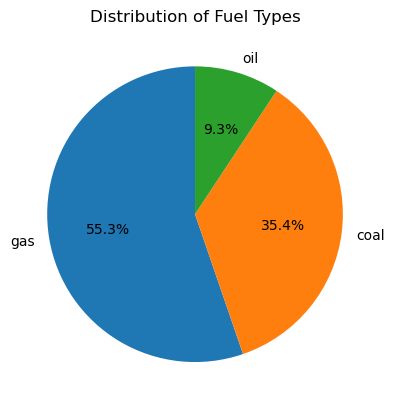

In [2]:
# distribution of fuel type
fuelCounts = trainData['fuel_type_code_pudl'].value_counts()

# Plot a pie chart
plt.pie(fuelCounts, labels=fuelCounts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Fuel Types')
plt.show()

In [3]:
avgCosts = allTrainData.groupby('fuel_type_code_pudl')['fuel_cost_per_mmbtu'].mean().reset_index()
avgCosts['fuel_cost_per_mmbtu'] = avgCosts['fuel_cost_per_mmbtu'].round(2)
avgCosts

,fuel_type_code_pudl,fuel_cost_per_mmbtu
0,coal,2.44
1,gas,19.73
2,oil,17.77


In [4]:
avgAsh = allTrainData.groupby('fuel_type_code_pudl')['ash_content_pct'].mean().reset_index()
avgAsh['ash_content_pct'] = avgAsh['ash_content_pct'].round(2)
avgAsh

,fuel_type_code_pudl,ash_content_pct
0,coal,9.57
1,gas,0.00
2,oil,0.00


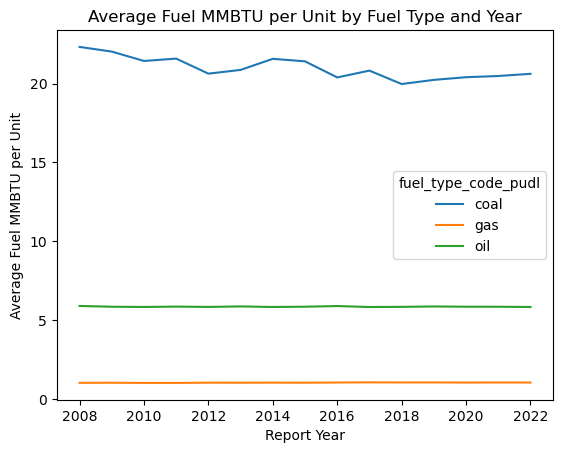

In [5]:
avgQuantValues = []
for type, group in allTrainData.groupby('fuel_type_code_pudl'):
    avgQuant = (group['fuel_mmbtu_per_unit']).groupby(group['report_year']).mean().reset_index()
    avgQuant['fuel_type_code_pudl'] = type
    avgQuantValues.append(avgQuant)

yearlyCosts = pd.concat(avgQuantValues)

sns.lineplot(x='report_year', y='fuel_mmbtu_per_unit', hue='fuel_type_code_pudl', data=yearlyCosts)
plt.title('Average Fuel MMBTU per Unit by Fuel Type and Year')
plt.xlabel('Report Year')
plt.ylabel('Average Fuel MMBTU per Unit')
plt.show()

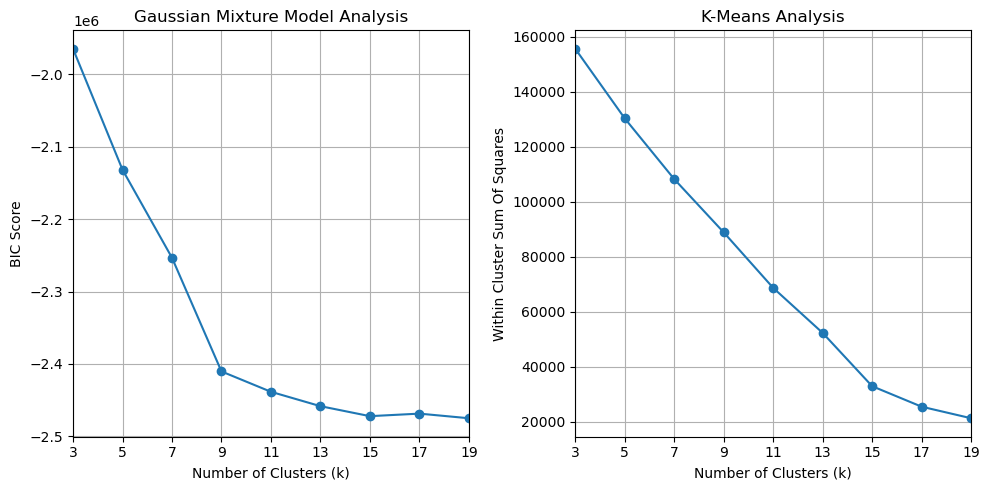

In [6]:
# analysis to find best clusters using gaussian mixture models and k-means
rangeOfClusters = [3, 5, 7, 9, 11, 13, 15, 17, 19]

bicScores = []
wcssValues = []

gmmSil = {}
kmSil = {}
aggSil = {}

scaler = StandardScaler()
trainScaled = scaler.fit_transform(trainData[numericalLabels])


for k in rangeOfClusters:
    # gmm 
    gmm = GaussianMixture(n_components=k, random_state=seed)
    gmm.fit(trainScaled)
    
    # gather bic scores for gmm
    bic = gmm.bic(trainScaled)
    bicScores.append(bic)

    # gather silhouette scores for gmm
    trainLabels = gmm.predict(trainScaled)
    gmmSil[k] = silhouette_score(trainScaled, trainLabels)

    # k-means
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(trainScaled)

    # gather wcss scores for k-means
    wcss = kmeans.inertia_
    wcssValues.append(wcss)

    # gather silhouette scores for k-means
    labels = kmeans.predict(trainScaled)
    kmSil[k] = silhouette_score(trainScaled, labels)

    # agglomerative clustering
    agglomerative = AgglomerativeClustering(n_clusters=k)
    agglomerative.fit(trainScaled)

    # gather silhouette scores for agglomerative clustering
    agglomerativeLabels = agglomerative.labels_
    aggSil[k] = silhouette_score(trainScaled, agglomerativeLabels)

# subplot for elbow method for gmm and k-means
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(rangeOfClusters, bicScores, marker='o')
plt.xlim(3, 19)
plt.title("Gaussian Mixture Model Analysis")
plt.xlabel("Number of Clusters (k)")
plt.xticks(np.arange(3, 20, step=2))
plt.ylabel("BIC Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rangeOfClusters, wcssValues, marker='o')
plt.xlim(3, 19)
plt.title("K-Means Analysis")
plt.xlabel("Number of Clusters (k)")
plt.xticks(np.arange(3, 20, step=2))
plt.ylabel("Within Cluster Sum Of Squares")
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# k-means table showing silhouette scores 
kmDF = pd.DataFrame(list(kmSil.items()), columns=[["Number of Clusters", "Silhouette Score"]])
kmDF

,Number of Clusters,Silhouette Score
0,3,0.449510
1,5,0.484278
2,7,0.496255
3,9,0.506451
4,11,0.533518
5,13,0.426265
6,15,0.434723
7,17,0.422172
8,19,0.402348


In [8]:
# gmm table showing silhouette scores
gmmDF = pd.DataFrame(list(gmmSil.items()), columns=[["Number of Clusters", "Silhouette Score"]])
gmmDF

,Number of Clusters,Silhouette Score
0,3,0.449510
1,5,0.298597
2,7,0.347805
3,9,0.536204
4,11,0.535432
5,13,0.541555
6,15,0.278165
7,17,0.216106
8,19,0.257746


In [9]:
aggDF = pd.DataFrame(list(aggSil.items()), columns=[["Number of Clusters", "Silhouette Score"]])
aggDF

,Number of Clusters,Silhouette Score
0,3,0.449510
1,5,0.491211
2,7,0.507518
3,9,0.522891
4,11,0.540344
5,13,0.542597
6,15,0.415348
7,17,0.416032
8,19,0.373708


In [10]:
# using best k to cluster 
bestK = 11

optimalKm = KMeans(n_clusters=bestK, random_state=seed)
optimalKm.fit(trainScaled)
trainLabels = optimalKm.predict(trainScaled)
clusteredDF = trainData.copy()

# add clusters and fuelCost to clusteredDF
clusteredDF['ClusterLabel'] = trainLabels + 1
clusteredDF[fuelCost] = fuelCostTrain

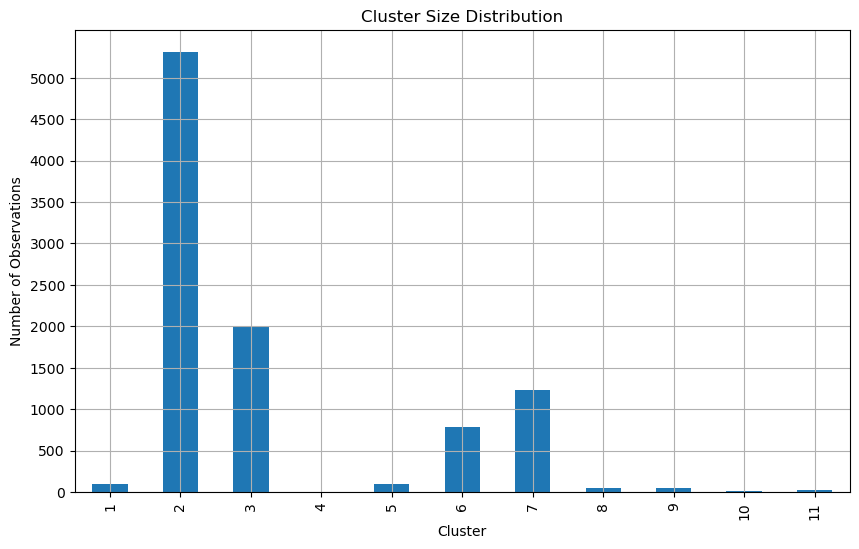

In [11]:
clusterSizes = clusteredDF["ClusterLabel"].value_counts()

plt.figure(figsize=(10, 6))
clusterSizes.sort_index().plot(kind='bar')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.yticks(np.arange(clusterSizes.max(), step=500))
plt.ylabel('Number of Observations')
plt.grid(True)
plt.show()

In [12]:
# analysis is conducted using the energy source that occurs the most within the cluster
# this analysis is not 100% accurate, but it does allow for generalized insight into
# power generation in the United States
byCluster = clusteredDF.dropna(axis=0).groupby("ClusterLabel")

sulfur = []
ash = []
modes = []
fuelPerUnit = []
costPerUnit = []
fuelReceived = []
overallCost = []

for cluster, group in byCluster:
    sulfur.append(np.average(group['sulfur_content_pct'].values))
    ash.append(np.average(group['ash_content_pct'].values))
    
    modeValue = group['fuel_type_code_pudl'].mode().loc[0]
    modes.append(modeValue)

    avgUnit = np.average(group['fuel_mmbtu_per_unit'].values)
    avgCost = np.average(group['fuel_cost_per_mmbtu'].values)
    totalReceived = np.average(group['fuel_received_units'].values)

    unitsReceived = totalReceived / avgUnit
    totalCost = unitsReceived * avgCost

    fuelPerUnit.append(avgUnit)
    costPerUnit.append(avgCost)
    fuelReceived.append(totalReceived)
    overallCost.append(totalCost)
    
clusterContent = pd.DataFrame({
    'Cluster Label': byCluster.groups.keys(),
    'Average Sulfur': sulfur,
    'Average Ash': ash,
    "Most Common Fuel Type": modes
})

toRound = ['Average Sulfur', 'Average Ash']
clusterContent[toRound] = clusterContent[toRound].round(2)

clusterContent

,Cluster Label,Average Sulfur,Average Ash,Most Common Fuel Type
0,1,2.42,31.10,coal
1,2,0.00,0.00,gas
2,3,1.87,10.51,coal
3,5,0.49,0.00,oil
4,6,0.08,0.00,oil
5,7,0.30,5.34,coal
6,8,5.15,0.36,coal
7,9,0.73,11.27,coal
8,11,0.00,0.00,gas


In [13]:
clusterCosts = pd.DataFrame({
    'Cluster Label': byCluster.groups.keys(),
    "Most Common Fuel Type": modes,
    "Fuel Per Unit": fuelPerUnit,
    "Cost Per Unit": costPerUnit,
    "Fuel Received": fuelReceived,
    "Total Cost": overallCost
})

toRound = ['Fuel Per Unit', 'Cost Per Unit', 'Fuel Received', 'Total Cost']
clusterCosts[toRound] = clusterCosts[toRound].round(2)
clusterCosts

,Cluster Label,Most Common Fuel Type,Fuel Per Unit,Cost Per Unit,Fuel Received,Total Cost
0,1,coal,17.58,2.33,32386.50,4288.89
1,2,gas,1.03,19.73,278665.31,5331135.92
2,3,coal,23.84,2.85,30690.62,3671.62
3,5,oil,6.33,13.28,76797.94,161031.44
4,6,oil,5.79,18.07,3669.89,11458.12
5,7,coal,17.52,1.87,69557.65,7438.69
6,8,coal,28.44,2.01,28280.85,2000.91
7,9,coal,13.57,2.20,222281.17,35953.34
8,11,gas,0.77,5.61,70639.50,517684.64


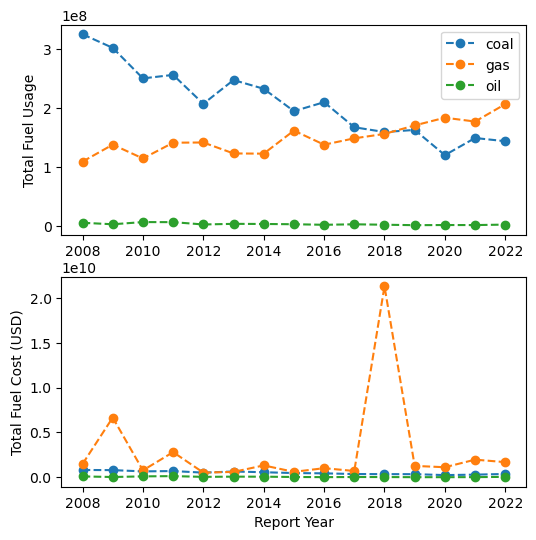

In [14]:

fig, axs = plt.subplots(2, 1, figsize=(6, 6))

for type, group in clusteredDF.groupby('fuel_type_code_pudl'):
    
    volume = (group['fuel_mmbtu_per_unit'] * group['fuel_received_units']).groupby(group['report_year']).sum()
    axs[0].plot(volume.index, volume, linestyle='dashed', marker='o', label=f'{type}')
    axs[0].set_ylabel('Total Fuel Usage')

    avgCost = group.groupby('report_year')['fuel_cost_per_mmbtu'].mean()
    totalCost = volume * avgCost
    axs[1].plot(totalCost.index, totalCost, linestyle='dashed', marker='o', label=f'{type}')
    axs[1].set_ylabel('Total Fuel Cost (USD)')


axs[0].legend()
axs[1].set_xticks(np.arange(2008, 2023, step=2))
axs[1].set_xlabel('Report Year')
plt.show()

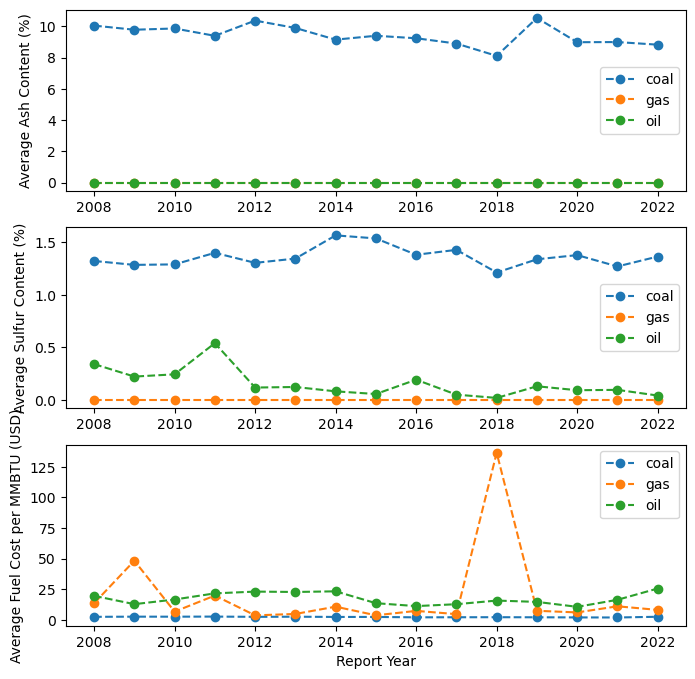

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

for type, group in clusteredDF.groupby('fuel_type_code_pudl'):
    avgAsh = group.groupby('report_year')['ash_content_pct'].mean()
    avgSulfur = group.groupby('report_year')['sulfur_content_pct'].mean()
    averageFuel = group.groupby('report_year')['fuel_cost_per_mmbtu'].mean()

    axs[0].plot(avgAsh.index, avgAsh, linestyle='dashed', marker='o', label=f'{type}')
    axs[0].set_ylabel('Average Ash Content (%)')
    
    axs[1].plot(avgSulfur.index, avgSulfur, linestyle='dashed', marker='o', label=f'{type}')
    axs[1].set_ylabel('Average Sulfur Content (%)')
    
    axs[2].plot(averageFuel.index, averageFuel, linestyle='dashed', marker='o', label=f'{type}')
    axs[2].set_ylabel('Average Fuel Cost per MMBTU (USD)')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[2].set_xlabel('Report Year')

# plt.tight_layout()
plt.show()

In [16]:
# multiple linear regression to find best variables
target = ['fuel_cost_per_mmbtu']
features = numericalLabels

train = clusteredDF
test = allTestData

train = train.dropna(axis=0)
test = test.dropna(axis=0)

xTrain = train[features]
yTrain = train[target]
xTrainScaled = scaler.fit_transform(xTrain)

ln = LinearRegression()
ln.fit(xTrainScaled, yTrain)

xTest = test[features]
xTestScaled = scaler.transform(xTest)
yPred = ln.predict(xTestScaled)

coef = ln.coef_
intercept = ln.intercept_

for f, c in zip(features, coef[0]):
    print(f"{f}: {c:.4f}")

# Output the intercept
print(f"Intercept: {intercept[0]:.4f}")

plant_id_eia: -3.2326
fuel_received_units: -4.3185
fuel_mmbtu_per_unit: 4.5329
sulfur_content_pct: -0.6376
ash_content_pct: 0.6368
report_year: 0.5010
report_month: 5.6586
report_day: 6317283745778.8350
fuel_type_code_pudl_coal: 46098501351369.3672
fuel_type_code_pudl_gas: 260151743131441.1250
fuel_type_code_pudl_oil: 20892896049154.3359
energy_source_code_BFG: -63551561306382.6094
energy_source_code_BIT: 38917915374617.3750
energy_source_code_DFO: 30566041118576.0352
energy_source_code_JF: 1996399785233.4324
energy_source_code_KER: -10884242034487.4727
energy_source_code_LIG: 6289639441163.5156
energy_source_code_NG: -165483648708675.8750
energy_source_code_OG: -5795508417290.4287
energy_source_code_PC: 6707346875320.2939
energy_source_code_PG: -8194837486748.0352
energy_source_code_RC: 0.0000
energy_source_code_RFO: 8211272270702.6465
energy_source_code_SC: 0.0000
energy_source_code_SGP: 0.0000
energy_source_code_SUB: 33939468309512.3633
energy_source_code_WC: 2340377263345.6460
ener

In [17]:
# feature selection using feature importances 
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

target = ['fuel_cost_per_mmbtu']
features = numericalLabels

predData = clusteredDF
predData = predData.dropna(axis=0)

x = predData[features]
y = predData[target]

model = RandomForestRegressor()
model.fit(x, y)  

imp = model.feature_importances_
top5 = []

for i, (feature, score) in enumerate(zip(x.columns, imp)):
    if i < 5:
        top5.append(feature)

print(top5)

['plant_id_eia', 'fuel_received_units', 'fuel_mmbtu_per_unit', 'sulfur_content_pct', 'ash_content_pct']


In [18]:
# feature selection using recursive feature elimination
rfe = RFE(model, n_features_to_select=5)  
fit = rfe.fit(x, y)  

featMask = fit.support_
selectedFeats = list(features[featMask])
print(selectedFeats)

['plant_id_eia', 'fuel_received_units', 'fuel_mmbtu_per_unit', 'report_year', 'report_month']


In [19]:
# combining findings from both methods as predictors
bestFeats = top5 + selectedFeats
print(bestFeats)

['plant_id_eia', 'fuel_received_units', 'fuel_mmbtu_per_unit', 'sulfur_content_pct', 'ash_content_pct', 'plant_id_eia', 'fuel_received_units', 'fuel_mmbtu_per_unit', 'report_year', 'report_month']


In [20]:
# making predictions 
x = predData[features]
y = predData[target]

model = RandomForestRegressor()
model.fit(x[bestFeats], y)

preds = model.predict(x[bestFeats])
predData.loc[:, target] = preds
clusteredDF.loc[:, target] = predData.loc[:, target]